In [117]:
from glob import glob
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler

target = 'datasets/CHI_EEG*'
files = glob(target)

def bw_bandpass(data, lowcut, highcut, fs, order = 2):
    nyquist = fs * 0.5
    low = lowcut / nyquist
    high = highcut / nyquist

    b, a = butter(order, [low, high], btype = 'band', output = 'ba', analog = False)
    return filtfilt(b, a, data, axis = 1)

def bw_notch5060(data, fs, order = 2):
    nyquist = fs * 0.5
    bp50 = np.array([49.0, 51.0]) / nyquist
    bp60 = np.array([59.0, 61.0]) / nyquist

    b, a = butter(order, bp50, btype = 'bandstop', output = 'ba', analog = False)
    data = filtfilt(b, a, data, axis = 1)

    b, a = butter(order, bp60, btype = 'bandstop', output = 'ba', analog = False)
    data = filtfilt(b, a, data, axis = 1)
    return data

def preprocess(x, freq = [0.5, 1], fs = 125, order = 2, norm = True):
    #remove dc offset
    x = x - x.mean()
    
    #apply notch filter
    x = bw_notch5060(x, fs, order)
    #apply filter
    x = bw_bandpass(x, lowcut=freq[0], highcut=freq[1], fs = fs, order = order)
    
    #normalize
    scaler = MinMaxScaler()
    if norm:
        for ch in range(x.shape[0]):
            x[ch, :] = scaler.fit_transform(x[ch, :].reshape(-1,1)).squeeze(1)        
    return x

xs = np.array([])
for f in sorted(files):
    t = np.expand_dims(preprocess(np.load(f)[1:17,:500], norm = False), 0)
    xs = np.concatenate([xs, t]) if xs.size else t
xs.shape

(52, 16, 500)

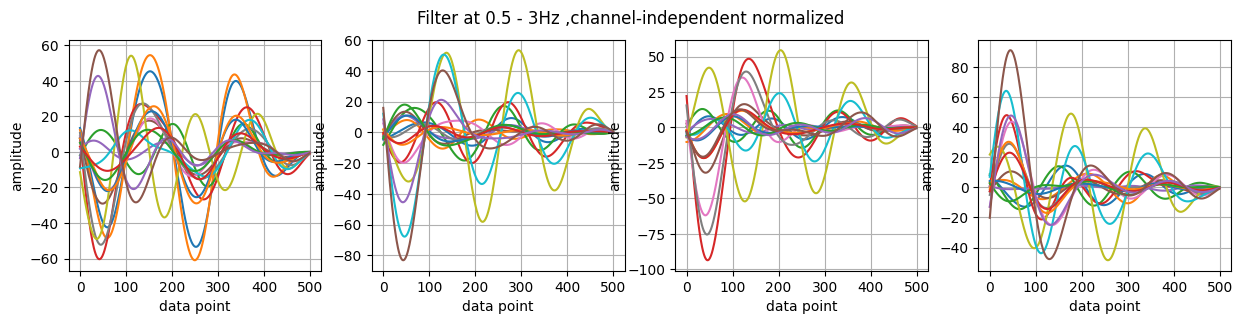

In [118]:
import matplotlib.pyplot as plt

scaler = MinMaxScaler((0,1))
rd = list(np.random.permutation(np.arange(0,10))[:4])
target_plot = xs[rd,:,:]
fig, axs = plt.subplots(1, 4, figsize = (15,3))
for i, ax in enumerate(axs):
    ax.plot(target_plot[i].T)
    ax.grid()
    ax.set_ylabel('amplitude')
    ax.set_xlabel('data point')
plt.suptitle('Filter at 0.5 - 3Hz ,channel-independent normalized')
plt.show()
    


(52, 100, 1)


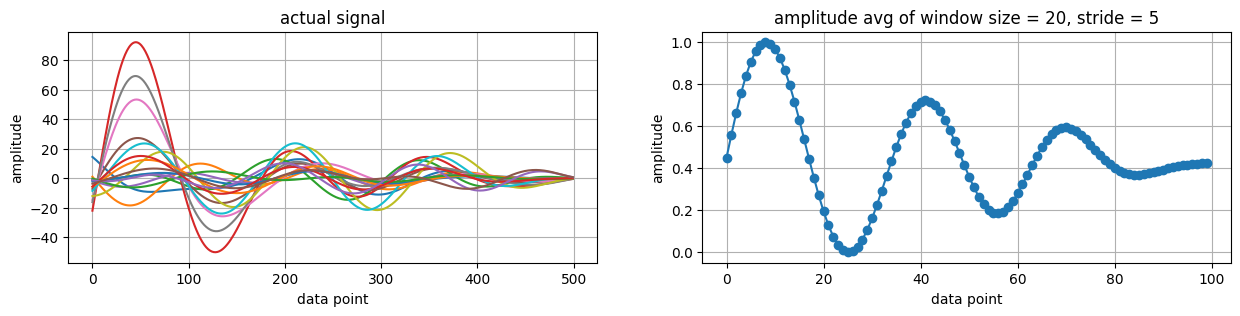

In [167]:
#find moving avg of amplitude with window size 50
plot = True
win_size = 20
stride = 5

scaler = MinMaxScaler((0,1))
x_avg = np.array([])
for x in xs:
    dx = []
    for win in range(0, 500, stride):
        t = x[:, win:win + win_size]
        dx.append(t.mean())
    dx = np.array(dx)
    dx = scaler.fit_transform(dx.reshape(-1,1)).reshape(1,-1,1)
    x_avg = np.concatenate([x_avg, dx]) if x_avg.size else dx

print(x_avg.shape)

if plot:
    rd = np.random.randint(0, len(x_avg))
    f, axs = plt.subplots(1,2, figsize = (15,3))

    axs[0].plot(xs[rd, :, :].T)
    axs[0].grid()
    axs[0].set_ylabel('amplitude')
    axs[0].set_xlabel('data point')
    axs[0].set_title('actual signal')

    axs[1].plot(x_avg[rd, :, :], 'o-')
    axs[1].grid()
    axs[1].set_ylabel('amplitude (normalized)')
    axs[1].set_xlabel('data point')
    axs[1].set_title(f'amplitude avg of window size = {win_size}, stride = {stride}')

In [106]:
# import math

# def dist_generator(d, x, param, noise = 0):
#     f = (math.exp(-x**2/(2.*param[0]**2))/(math.sqrt(2*math.pi)*param[0]))+param[1]
#     return f+(noise*(np.random.rand()-0.5)/100.)

# def generate_demonstrations(time_len = 200, params = None, title = None):
#     fig = plt.figure(figsize=(5,5))
#     x = np.linspace(-0.5,0.5,time_len)
#     times = np.zeros((params.shape[0],time_len,1))
#     times[:] = x.reshape((1,time_len,1))+0.5
#     values = np.zeros((params.shape[0],time_len,1))
#     for d in range(params.shape[0]):
#             for i in range(time_len):
#                 values[d,i] = dist_generator(d,x[i],params[d])
#             plt.plot(times[d], values[d])
#     plt.title(title+' Demonstrations')
#     plt.ylabel('Y')
#     plt.xlabel('time (t)')
#     plt.show()
#     return times, values

# X, Y = generate_demonstrations(time_len=200, params=np.array([[0.6,-0.1],[0.5,-0.23],[0.4,-0.43],[-0.6,0.1],[-0.5,0.23],[-0.4,0.43]]), title='Training')
# v_X, v_Y = generate_demonstrations(time_len=200, params=np.array([[0.55,-0.155],[0.45,-0.32],[-0.45,0.32],[-0.55,0.155]]), title='Validation')
# print('training X ', X.shape)
# print('training Y ',Y.shape)
# print('validation X ', v_X.shape)
# print('validation Y ',v_Y.shape)

In [168]:
import torch
def get_train_sample(x, xt, time_len = 20, obs_max = 5, device = 'cpu'):
    traj_len = np.random.randint(0, obs_max) + 1 #random length
    demons = np.random.randint(0, x.shape[0]) #random demonsration
    
    observations = np.zeros((traj_len, 2))
    target_time = np.zeros((1, 1))
    target_point = np.zeros((1,1))

    perm = np.random.permutation(time_len)
    observations[:traj_len, :1] = xt[demons, perm[:traj_len]]
    observations[:traj_len, 1:] = x[demons, perm[:traj_len]]
    target_time[0] = xt[demons, perm[-1]]
    target_point[0] = x[demons, perm[-1]]

    return (torch.from_numpy(observations).to(device),
            torch.from_numpy(target_time).to(device),
            torch.from_numpy(target_point).to(device))


#prepare the data
t = np.linspace(0., 1., x_avg.shape[1]).reshape(x_avg.shape[1],1)

#CAPILAB AVG EEG Data
Xs = x_avg[:-12,:,:]
Xt = np.ones(Xs.shape) * t
vXs = x_avg[-12:,:,:]
vXt = np.ones(vXs.shape) * t

# #Test data
# Xs = Y
# Xt = X
# vXs = v_Y
# vXt = v_X

# obs, xt, ys = get_train_sample(Xs, Xt, Xs.shape[1], Xs.shape[1] / 4)
# obs.shape
print(Xs.shape, Xt.shape, vXs.shape, vXt.shape)

(40, 100, 1) (40, 100, 1) (12, 100, 1) (12, 100, 1)


In [169]:
import torch
def evaluate_model(tmodel, vxs, vxt, predict_len = 20, plot = True):
    colors = ['r', 'g', 'b', 'c', 'k'] * (vxs.shape[1] * predict_len)
    selected = np.random.randint(0,len(vXs))
    val_data = vxs[selected]
    val_time = vxt[selected]
    tmodel.eval()


    stds = np.array([])
    pts = np.array([])
    with torch.no_grad():
        if plot:
            _, axs = plt.subplots(2,1, figsize = (10,7), sharex= True)

        for i in range(0, val_data.shape[0], predict_len):#get first point, predict 19 point each until end
            #current observation with time
            
            obs = np.concatenate([val_data[i], val_time[i]]).reshape(1,2)
            obs = torch.from_numpy(obs)
            # target_t = torch.from_numpy(np.array([val_time[i + predict_len - 1]]))
            #sequence of target time
            target_t = torch.from_numpy(val_time[range(i, i + predict_len)])
            
            # #predict 19 point
            yhat = tmodel(obs, target_t).detach().cpu().numpy()

            predicted_points = yhat[:, 0]
            predicted_stds = yhat[:, 1]
            predicted_stds = np.log(1 + np.exp(predicted_stds))

            pts = np.concatenate([pts, predicted_points]) if pts.size else predicted_points
            stds = np.concatenate([stds, predicted_stds]) if stds.size else predicted_stds

            if plot:
            #plot actual signal in prediction interval and observation point
                obs = obs.detach().cpu().numpy()[0]
                color = colors[i//predict_len]
                axs[0].plot(obs[1], obs[0], 'o', label = f'obs t = {val_time[i][0]:.3f}', color = color)
                axs[0].plot(val_time[i:i + predict_len], val_data[i:i + predict_len], alpha = 0.5,color = color)
                axs[0].set_title('actual signal and observation point')
                axs[0].grid()
                axs[0].set_xlabel('time')
                axs[0].set_ylabel('amplitude')
                # axs[0].legend(loc = 'upper right')

                #plot prediction and error
                target_t = target_t.detach().cpu().numpy()
                axs[1].plot(target_t, predicted_points, 'x-', color = color)
                axs[1].plot(obs[1], obs[0], 'o', label = f'obs t = {val_time[i][0]:.3f}', color = color)
                axs[1].set_title('predicted signal from each observation point')
                axs[1].grid()
                axs[1].set_xlabel('time')
                axs[1].set_ylabel('amplitude')
                print(target_t.shape, predicted_points.shape, predicted_stds.shape)
                axs[1].errorbar(target_t, predicted_points,yerr=predicted_stds,color = 'black',alpha=0.4)
        if plot:
            plt.show()
    return pts, stds

In [108]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EEG_CNMP(nn.Module):
    def __init__(self, **args):
        super(EEG_CNMP, self).__init__()
        # Encoder takes observations which are (X,Y) tuples and produces latent representations for each of them
        self.encoder = nn.Sequential(
        nn.Linear(2,128),nn.ReLU(),
        nn.Linear(128,128),nn.ReLU(),
        nn.Linear(128,128),nn.ReLU(),
        nn.Linear(128,128)
        )
        
        #Decoder takes the (r_mean, target_t) tuple and produces mean and std values for each dimension of the output
        self.decoder = nn.Sequential(
        nn.Linear(129,128),nn.ReLU(),
        nn.Linear(128,128),nn.ReLU(),
        nn.Linear(128,128),nn.ReLU(),
        nn.Linear(128,2)
        )

    def forward(self, xs, xt):
        r = self.encoder(xs) # Generating observations
        r_mean = torch.mean(r,dim=0) # Taking mean and generating the general representation
        r_mean = r_mean.repeat(xt.shape[0],1) # Duplicating general representation for every target_t
        concat = torch.cat((r_mean,xt),dim=-1) # Concatenating each target_t with general representation
        y = self.decoder(concat) # Producing mean and std values for each target_t
        return y

def log_prob_loss(yhat, y):
    mean, sigma = yhat.chunk(2, dim = -1) #output of cnmp contain data and std at each half
    sigma = F.softplus(sigma)
    dist = torch.distributions.Independent(torch.distributions.Normal(loc=mean, scale=sigma), 1)
    return -torch.mean(dist.log_prob(y))

Plotting train data
(100, 1) (100,) (100,)


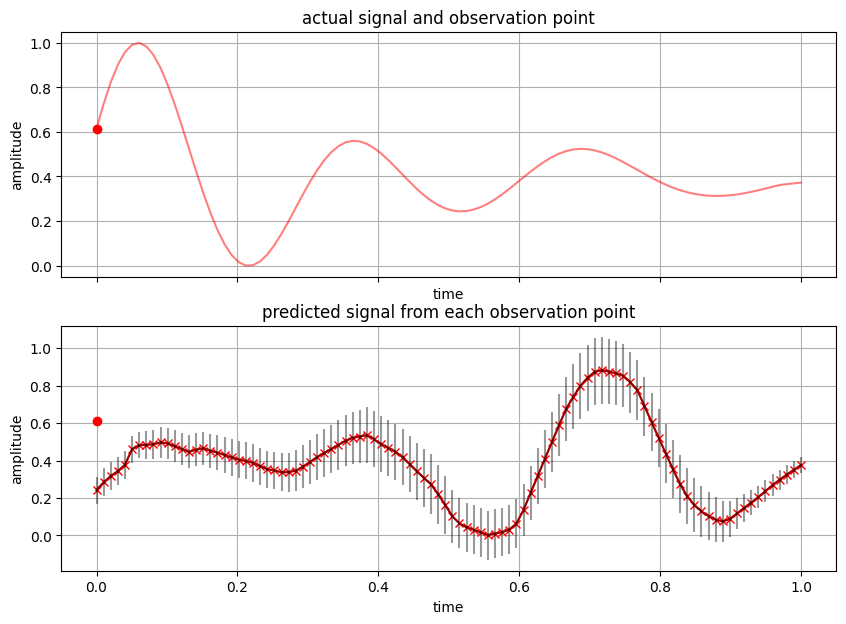

100%|██████████| 5000000/5000000 [2:00:48<00:00, 689.82it/s]


In [170]:
#train loop
from IPython.display import clear_output
from tqdm import tqdm

device = 'cpu'
model = EEG_CNMP().to(device).double()
optim = torch.optim.Adam(model.parameters(), lr = 1e-4)
criteria = log_prob_loss

epochs = int(5e6)
plot_val_ckpt = 50000
plot_train_ckpt = 7000
save_ckpt = 500_000

epochs_loss = []
with tqdm(range(epochs)) as pbar:
    for epoch in range(epochs):
        obs, xt, y = get_train_sample(Xs, Xt, Xs.shape[1], obs_max = 30)

        #train model
        optim.zero_grad()
        yhat = model(obs, xt) 
        loss = criteria(yhat, y)
        loss.backward()
        optim.step()

        epochs_loss.append(loss.item())
        if (epoch + 1) % plot_train_ckpt == 0:
            clear_output(True)
            print('Plotting train data')
            pt, std = evaluate_model(tmodel = model, vxs = Xs, vxt = Xt, predict_len=Xt.shape[1]) 

        if (epoch + 1) % save_ckpt == 0:
            torch.save(model, f'ckpt_epoch{epoch}')
    
        # if (epoch + 1) % plot_val_ckpt:
        #     clear_output(True)
        #     print('Plotting validation data')
        #     pt, std = evaluate_model(tmodel = model, vxs = vXs, vxt = vXt) 
        
        pbar.update(1)

    

(100, 1) (100,) (100,)


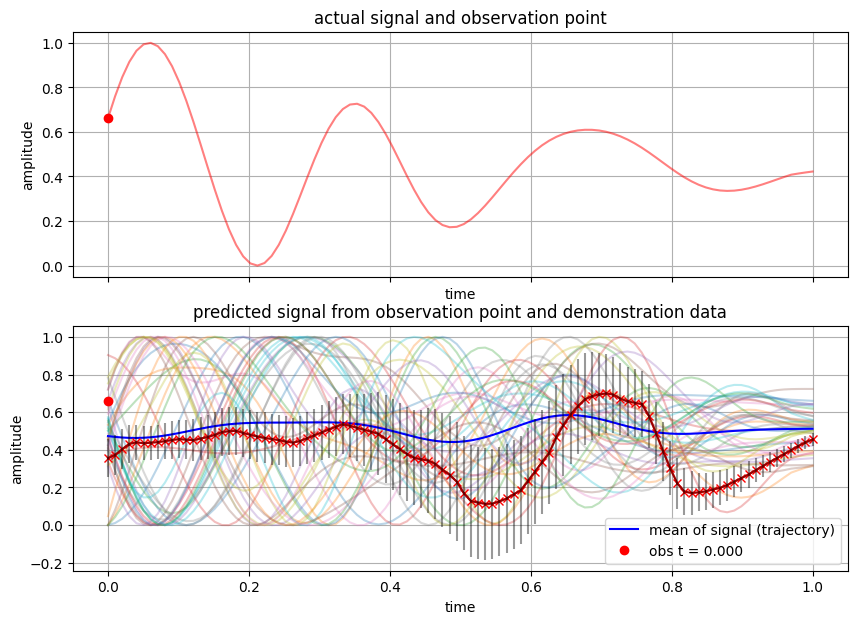

In [271]:
import torch
def evaluate_model(tmodel, vxs, vxt, predict_len = 20, plot = True, show_all_demons = True):
    colors = ['r', 'g', 'b', 'c', 'k'] * (vxs.shape[1] * predict_len)
    selected = np.random.randint(0,len(vXs))
    val_data = vxs[selected]
    val_time = vxt[selected]
    tmodel.eval()


    stds = np.array([])
    pts = np.array([])
    with torch.no_grad():
        if plot:
            _, axs = plt.subplots(2,1, figsize = (10,7), sharex= True)

        for i in range(0, val_data.shape[0], predict_len):#get first point, predict 19 point each until end
            #current observation with time
            
            obs = np.concatenate([val_data[i], val_time[i]]).reshape(1,2)
            obs = torch.from_numpy(obs)
            # target_t = torch.from_numpy(np.array([val_time[i + predict_len - 1]]))
            #sequence of target time
            target_t = torch.from_numpy(val_time[range(i, i + predict_len)])
            
            # #predict 19 point
            yhat = tmodel(obs, target_t).detach().cpu().numpy()

            predicted_points = yhat[:, 0]
            predicted_stds = yhat[:, 1]
            predicted_stds = np.log(1 + np.exp(predicted_stds))

            pts = np.concatenate([pts, predicted_points]) if pts.size else predicted_points
            stds = np.concatenate([stds, predicted_stds]) if stds.size else predicted_stds

            if plot:
            #plot actual signal in prediction interval and observation point
                obs = obs.detach().cpu().numpy()[0]
                color = colors[i//predict_len]
                axs[0].plot(obs[1], obs[0], 'o', label = f'obs t = {val_time[i][0]:.3f}', color = color)
                axs[0].plot(val_time[i:i + predict_len], val_data[i:i + predict_len], alpha = 0.5,color = color)
                axs[0].set_title('actual signal and observation point')
                axs[0].grid()
                axs[0].set_xlabel('time')
                axs[0].set_ylabel('amplitude')
                # axs[0].legend(loc = 'upper right')

                #plot prediction and error
                target_t = target_t.detach().cpu().numpy()
                for demon, t in zip(vxs, vxt):
                    axs[1].plot(t[:,0], demon[:,0], alpha = 0.3)
                axs[1].plot(vxt[0], vxs.mean(0), color = 'b',label = 'mean of signal (trajectory)')
                axs[1].plot(target_t, predicted_points, 'x-', color = color)
                axs[1].plot(obs[1], obs[0], 'o', label = f'obs t = {val_time[i][0]:.3f}', color = color)
                axs[1].set_title('predicted signal from observation point and demonstration data')
                axs[1].grid()
                axs[1].set_xlabel('time')
                axs[1].set_ylabel('amplitude')
                print(target_t.shape, predicted_points.shape, predicted_stds.shape)
                axs[1].errorbar(target_t, predicted_points,yerr=predicted_stds,color = 'black',alpha=0.4)
        if plot:
            plt.legend()
            plt.show()
    return pts, stds

model = EEG_CNMP().double()
model = torch.load('ckpt_epoch4999999')
model.eval()
pt, std = evaluate_model(tmodel = model, vxs = Xs, vxt = Xt, predict_len=100, plot=True) 